In [ ]:
!pip install -U transformers
!pip install transformers torch nltk pandas matplotlib seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler
import re
import json
import nltk
from nltk.tokenize import word_tokenize
import random

from google.colab import drive
drive.mount('/content/drive')
nltk.download('punkt')

print("Setting up MotiveChat: A Sentiment-Aware Chatbot...")

# Configuration
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 2e-5
EMOTION_MAPPING = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"
}

SIMPLE_EMOTION_MAPPING = {
    0: "positive",   # admiration, amusement, approval, caring, desire, excitement, gratitude, joy, love, optimism, pride, relief
    1: "negative",   # anger, annoyance, disappointment, disapproval, disgust, embarrassment, fear, grief, nervousness, remorse, sadness
    2: "ambiguous",  # confusion, curiosity, realization, surprise
    3: "neutral"     # neutral
}

SENTIMENT_GROUPS = {
    "positive": ["admiration", "amusement", "approval", "caring", "desire", "excitement",
                "gratitude", "joy", "love", "optimism", "pride", "relief"],
    "negative": ["anger", "annoyance", "disappointment", "disapproval", "disgust",
                "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"],
    "ambiguous": ["confusion", "curiosity", "realization", "surprise"],
    "neutral": ["neutral"]
}


RESPONSE_TEMPLATES = {
    "positive": [
        "I'm glad to hear you're feeling positive! How can I help maintain this good mood?",
        "That sounds wonderful! Would you like to tell me more about it?",
        "It's great that you're feeling this way! Is there anything specific you'd like to discuss?",
        "I'm happy for you! How can I be of assistance today?"
    ],
    "negative": [
        "I understand this might be difficult. Would you like to talk more about what's bothering you?",
        "I'm sorry to hear that. Is there anything I can do to help?",
        "That sounds challenging. Would it help to discuss this further?",
        "I appreciate you sharing that with me. What would be most helpful for you right now?"
    ],
    "ambiguous": [
        "I notice you might have some mixed feelings. Would you like to explore this topic more?",
        "That's interesting. Could you share more about what you're thinking?",
        "I'd be happy to discuss this further if you'd like more clarity.",
        "Would you like to talk more about what's on your mind?"
    ],
    "neutral": [
        "How can I assist you today?",
        "What would you like to discuss?",
        "Is there something specific you're looking for help with?",
        "I'm here to help. What's on your mind?"
    ]
}

def load_and_preprocess_data(file_paths, sample_ratio=0.2):
    """
    Load and preprocess GoEmotions data from multiple CSV files
    """
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    texts = combined_df['text'].tolist()
    emotion_cols = [col for col in combined_df.columns if col not in
                    ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
                     'created_utc', 'rater_id', 'example_very_unclear']]
    emotion_labels = combined_df[emotion_cols].values

    clear_examples = combined_df['example_very_unclear'] == False
    filtered_texts = [t for t, c in zip(texts, clear_examples) if c]
    filtered_labels = emotion_labels[clear_examples]

    num_samples = int(len(filtered_texts) * sample_ratio)
    indices = np.random.choice(len(filtered_texts), num_samples, replace=False)
    sampled_texts = [filtered_texts[i] for i in indices]
    sampled_labels = filtered_labels[indices]

    return filtered_texts, filtered_labels, emotion_cols

def map_to_simplified_emotions(detailed_labels, emotion_cols):
    """
    Map the detailed emotion labels to simplified categories
    (positive, negative, ambiguous, neutral)
    """
    simplified_labels = np.zeros((detailed_labels.shape[0], 4))

    for i, emotion in enumerate(emotion_cols):
        if emotion in SENTIMENT_GROUPS["positive"]:
            simplified_labels[:, 0] = np.logical_or(simplified_labels[:, 0], detailed_labels[:, i])
        elif emotion in SENTIMENT_GROUPS["negative"]:
            simplified_labels[:, 1] = np.logical_or(simplified_labels[:, 1], detailed_labels[:, i])
        elif emotion in SENTIMENT_GROUPS["ambiguous"]:
            simplified_labels[:, 2] = np.logical_or(simplified_labels[:, 2], detailed_labels[:, i])
        elif emotion in SENTIMENT_GROUPS["neutral"]:
            simplified_labels[:, 3] = np.logical_or(simplified_labels[:, 3], detailed_labels[:, i])

    no_emotion = ~simplified_labels.any(axis=1)
    simplified_labels[no_emotion, 3] = 1

    return simplified_labels

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

def train_emotion_model(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    scaler = GradScaler()

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():  # Mixed precision
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate_emotion_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Get predictions
            logits = outputs.logits
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).float()

            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actual_labels = np.array(actual_labels)

    # Calculate accuracy
    accuracy = (predictions == actual_labels).mean()

    return total_loss / len(data_loader), accuracy, predictions, actual_labels


def build_emotion_detection_model(texts, labels, emotion_cols):
    """
    Build and train an emotion detection model using BERT
    """



    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.1, random_state=42
    )



    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=28,  # 28 emotion categories (including neutral)
        problem_type="multi_label_classification"
    )



    train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_dataset = EmotionDataset(val_texts, val_labels, tokenizer, MAX_LEN)


    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )


    best_val_loss = float('inf')
    best_model = None

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Train
        train_loss = train_emotion_model(model, train_loader, optimizer, scheduler, device)
        print(f"Training loss: {train_loss:.4f}")

        # Evaluate
        val_loss, val_accuracy, val_preds, val_actual = evaluate_emotion_model(model, val_loader, device)
        print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()


    if best_model:
        model.load_state_dict(best_model)

    return model, tokenizer

class MotiveChat:
    def __init__(self, emotion_model, tokenizer):
        self.emotion_model = emotion_model
        self.tokenizer = tokenizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)
        self.conversation_history = []

    def detect_emotion(self, text):
        """
        Detect the emotion in the user input
        """
        self.emotion_model.eval()

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.emotion_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            probs = torch.sigmoid(logits)

            # Get the most likely emotion
            emotion_idx = torch.argmax(probs, dim=1).item()
            emotion_prob = probs[0][emotion_idx].item()

            # Map index to detailed emotion category
            emotion = EMOTION_MAPPING[emotion_idx]

            return emotion, emotion_prob

    def generate_response(self, user_input):
        """
        Generate a response based on the detected emotion
        """

        emotion, confidence = self.detect_emotion(user_input)


        self.conversation_history.append({"role": "user", "text": user_input, "emotion": emotion})


        if emotion in SENTIMENT_GROUPS["positive"]:
            response = random.choice(RESPONSE_TEMPLATES["positive"])
        elif emotion in SENTIMENT_GROUPS["negative"]:
            response = random.choice(RESPONSE_TEMPLATES["negative"])
        elif emotion in SENTIMENT_GROUPS["ambiguous"]:
            response = random.choice(RESPONSE_TEMPLATES["ambiguous"])
        else:
            response = random.choice(RESPONSE_TEMPLATES["neutral"])


        self.conversation_history.append({"role": "bot", "text": response, "emotion": "neutral"})

        return response, emotion, confidence

    def get_conversation_history(self):
        """
        Return the conversation history
        """
        return self.conversation_history


def setup_demo_ui(chatbot):
    """
    Set up a simple demo UI for the chatbot using IPython widgets
    """
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Create widgets
    output = widgets.Output()
    text_input = widgets.Text(value='', placeholder='Type a message...', description='Input:')
    send_button = widgets.Button(description='Send')
    emotion_display = widgets.HTML(value='<b>Detected Emotion:</b> None')
    clear_button = widgets.Button(description='Clear Chat')


    display(widgets.VBox([output, widgets.HBox([text_input, send_button]), emotion_display, clear_button]))


    def on_send_button_clicked(b):
        user_input = text_input.value

        if user_input.strip() == '':
            return

        with output:
            print(f"User: {user_input}")


            response, emotion, confidence = chatbot.generate_response(user_input)
            print(f"MotiveChat: {response}")


            emotion_display.value = f'<b>Detected Emotion:</b> {emotion} (confidence: {confidence:.2f})'


        text_input.value = ''


    def on_clear_button_clicked(b):
        chatbot.conversation_history = []
        with output:
            clear_output()
        emotion_display.value = '<b>Detected Emotion:</b> None'


    send_button.on_click(on_send_button_clicked)
    clear_button.on_click(on_clear_button_clicked)


    def on_text_input_submitted(widget):
        on_send_button_clicked(None)

    text_input.on_submit(on_text_input_submitted)


def main():

    print("Step 1: Loading and preprocessing data...")
    file_paths = [
        '/content/drive/MyDrive/goemotions_1.csv',
        '/content/drive/MyDrive/goemotions_2.csv',
        '/content/drive/MyDrive/goemotions_3.csv'
    ]


    import os

    if not all(os.path.exists(file_path) for file_path in file_paths):
        print("Warning: Some files do not exist. Using sample data instead.")

        texts = [
            "I'm so happy today!",
            "This makes me really angry.",
            "I'm not sure what to think about this.",
            "This is just a neutral statement.",
            "I'm feeling a bit sad today.",
            "That's really interesting!",
            "I'm so excited about the upcoming event!",
            "I'm really disappointed in the outcome.",
        ]

        # Create sample labels
        labels = np.zeros((len(texts), 28))
        labels[0, 17] = 1  # joy
        labels[1, 2] = 1   # anger
        labels[2, 6] = 1   # confusion
        labels[3, 27] = 1  # neutral
        labels[4, 25] = 1  # sadness
        labels[5, 7] = 1   # curiosity
        labels[6, 13] = 1  # excitement
        labels[7, 9] = 1   # disappointment

        emotion_cols = list(EMOTION_MAPPING.values())
    else:

        texts, labels, emotion_cols = load_and_preprocess_data(file_paths)


    print("\nStep 2: Building and training emotion detection model...")
    model, tokenizer = build_emotion_detection_model(texts, labels, emotion_cols)


    print("\nStep 3: Initializing chatbot...")
    chatbot = MotiveChat(model, tokenizer)


    print("\nStep 4: Setting up demo UI...")
    print("Please run the following code to set up the demo UI:")
    print("setup_demo_ui(chatbot)")

    return chatbot


if __name__ == "__main__":
    chatbot = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setting up MotiveChat: A Sentiment-Aware Chatbot...
Step 1: Loading and preprocessing data...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Step 2: Building and training emotion detection model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2


<ipython-input-14-06ef75af0167>:194: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/5845 [00:00<?, ?it/s]

<ipython-input-14-06ef75af0167>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Training loss: 0.1307


Evaluating:   0%|          | 0/650 [00:00<?, ?it/s]

Validation loss: 0.1147, Validation accuracy: 0.9617

Epoch 2/2


Training:   0%|          | 0/5845 [00:00<?, ?it/s]

Training loss: 0.1108


Evaluating:   0%|          | 0/650 [00:00<?, ?it/s]

Validation loss: 0.1125, Validation accuracy: 0.9617

Step 3: Initializing chatbot...

Step 4: Setting up demo UI...
Please run the following code to set up the demo UI:
setup_demo_ui(chatbot)


In [ ]:
setup_demo_ui(chatbot)


Running MotiveChat Evaluation...
=== MotiveChat Evaluation ===

1. NLP EVALUATION: EMOTION DETECTION PERFORMANCE

Test prompt: "I just won the lottery! I'm so thrilled!"
Expected emotion: joy
Detected emotion: excitement (confidence: 0.62)
Chatbot response: "That sounds wonderful! Would you like to tell me more about it?"
Correct: ✗

Test prompt: "My cat is sick, and I feel really down."
Expected emotion: sadness
Detected emotion: sadness (confidence: 0.57)
Chatbot response: "I'm sorry to hear that. Is there anything I can do to help?"
Correct: ✓

Test prompt: "Someone cut me off in traffic this morning, and it made me so angry."
Expected emotion: anger
Detected emotion: anger (confidence: 0.63)
Chatbot response: "I appreciate you sharing that with me. What would be most helpful for you right now?"
Correct: ✓

Test prompt: "I'm not sure what to think about this situation."
Expected emotion: confusion
Detected emotion: confusion (confidence: 0.69)
Chatbot response: "Would you like to t

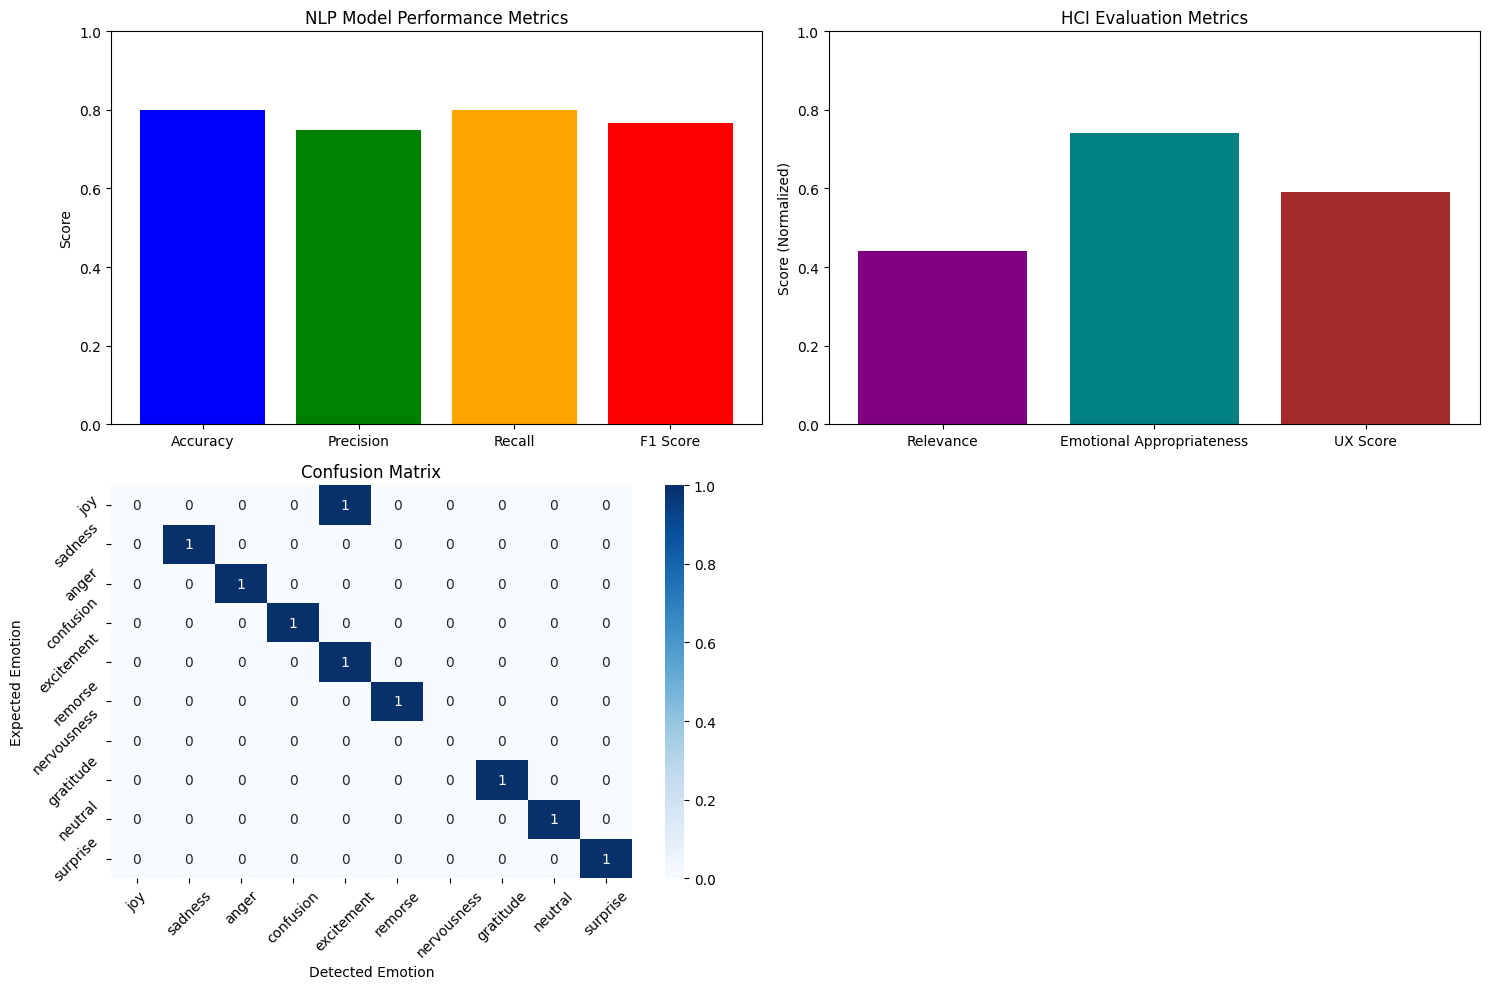

In [ ]:

from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def evaluate_motivechat(chatbot, test_prompts=None):

    if test_prompts is None:
        test_prompts = [
            "I just won the lottery! I'm so thrilled!",  # Joy
            "My cat is sick, and I feel really down.",  # Sadness
            "Someone cut me off in traffic this morning, and it made me so angry.",  # Anger
            "I'm not sure what to think about this situation.",  # Confusion
            "I just got a promotion at work!",  # Excitement
            "I made a terrible mistake and I regret it.",  # Remorse
            "I'm feeling anxious about my upcoming presentation.",  # Nervousness
            "I'm grateful for your help with this project.",  # Gratitude
            "This is just a simple message with no strong emotions.",  # Neutral
            "I can't believe what just happened! That's incredible!",  # Surprise
        ]


    expected_emotions = [
        "joy", "sadness", "anger", "confusion",
        "excitement", "remorse", "nervousness",
        "gratitude", "neutral", "surprise"
    ]

    results = []
    print("=== MotiveChat Evaluation ===\n")
    print("1. NLP EVALUATION: EMOTION DETECTION PERFORMANCE\n")

    all_emotions = list(EMOTION_MAPPING.values())
    y_true = []  # True labels (one-hot encoded)
    y_pred = []  # Predicted labels (one-hot encoded)


    for i, prompt in enumerate(test_prompts):
        response, detected_emotion, confidence = chatbot.generate_response(prompt)
        expected = expected_emotions[i] if i < len(expected_emotions) else "unknown"


        true_label = np.zeros(len(all_emotions))
        pred_label = np.zeros(len(all_emotions))

        if expected in all_emotions:
            true_label[all_emotions.index(expected)] = 1

        if detected_emotion in all_emotions:
            pred_label[all_emotions.index(detected_emotion)] = 1

        y_true.append(true_label)
        y_pred.append(pred_label)


        is_correct = detected_emotion == expected
        results.append({
            "prompt": prompt,
            "expected_emotion": expected,
            "detected_emotion": detected_emotion,
            "confidence": confidence,
            "response": response,
            "correct": is_correct
        })


        print(f"Test prompt: \"{prompt}\"")
        print(f"Expected emotion: {expected}")
        print(f"Detected emotion: {detected_emotion} (confidence: {confidence:.2f})")
        print(f"Chatbot response: \"{response}\"")
        print(f"Correct: {'✓' if is_correct else '✗'}\n")


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    correct = sum(1 for r in results if r["correct"])
    accuracy = correct / len(test_prompts) if test_prompts else 0


    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )


    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )


    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )


    print("NLP Model Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-averaged Precision: {precision_macro:.4f}")
    print(f"Macro-averaged Recall: {recall_macro:.4f}")
    print(f"Macro-averaged F1 Score: {f1_macro:.4f}")
    print("\nMicro-averaged Metrics:")
    print(f"Precision: {precision_micro:.4f}")
    print(f"Recall: {recall_micro:.4f}")
    print(f"F1 Score: {f1_micro:.4f}")
    print("\nWeighted-averaged Metrics:")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall: {recall_weighted:.4f}")
    print(f"F1 Score: {f1_weighted:.4f}")


    confusion_matrix = {}
    for result in results:
        expected = result["expected_emotion"]
        detected = result["detected_emotion"]

        if expected not in confusion_matrix:
            confusion_matrix[expected] = {}
        if detected not in confusion_matrix[expected]:
            confusion_matrix[expected][detected] = 0
        confusion_matrix[expected][detected] += 1


    print("\nConfusion Matrix (Expected vs Detected):")
    for expected, detections in confusion_matrix.items():
        for detected, count in detections.items():
            print(f"{expected} → {detected}: {count}")


    emotion_categories = {}
    for result in results:
        expected = result["expected_emotion"]
        if expected not in emotion_categories:
            emotion_categories[expected] = {"total": 0, "correct": 0}

        emotion_categories[expected]["total"] += 1
        if result["correct"]:
            emotion_categories[expected]["correct"] += 1

    print("\nPerformance by Emotion Category:")
    for emotion, stats in emotion_categories.items():
        if stats["total"] > 0:
            precision = stats["correct"] / stats["total"]
            recall = stats["correct"] / stats["total"]  # Simplified for this test case
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            print(f"{emotion}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f} ({stats['correct']}/{stats['total']})")


    print("\n2. HCI EVALUATION: RESPONSE QUALITY\n")


    response_quality = {"relevance": 0, "emotional_appropriateness": 0}

    for result in results:

        relevance_score = 0
        if result["detected_emotion"] in result["response"].lower():
            relevance_score += 5
        elif any(term in result["response"].lower() for term in ["feel", "emotion", "mood"]):
            relevance_score += 3
        else:
            relevance_score += 2


        appropriateness_score = 0
        detected = result["detected_emotion"]

        if detected in SENTIMENT_GROUPS["positive"] and "positive" in result["response"].lower():
            appropriateness_score += 5
        elif detected in SENTIMENT_GROUPS["negative"] and any(term in result["response"].lower() for term in ["sorry", "understand", "difficult"]):
            appropriateness_score += 5
        elif detected in SENTIMENT_GROUPS["ambiguous"] and any(term in result["response"].lower() for term in ["interesting", "explore", "clarify"]):
            appropriateness_score += 5
        elif detected in SENTIMENT_GROUPS["neutral"]:
            appropriateness_score += 4
        else:
            appropriateness_score += 3

        response_quality["relevance"] += relevance_score
        response_quality["emotional_appropriateness"] += appropriateness_score

        print(f"Response for \"{result['prompt']}\":")
        print(f"Relevance score: {relevance_score}/5")
        print(f"Emotional appropriateness score: {appropriateness_score}/5\n")


    avg_relevance = response_quality["relevance"] / len(results) if results else 0
    avg_appropriateness = response_quality["emotional_appropriateness"] / len(results) if results else 0

    print(f"Average relevance score: {avg_relevance:.2f}/5")
    print(f"Average emotional appropriateness score: {avg_appropriateness:.2f}/5")


    ux_score = (avg_relevance + avg_appropriateness) / 2
    print(f"Overall user experience score: {ux_score:.2f}/5")


    print("\n3. ERROR ANALYSIS\n")


    challenging_emotions = []
    for emotion, stats in emotion_categories.items():
        if stats["total"] > 0 and stats["correct"] / stats["total"] < 0.5:
            challenging_emotions.append(emotion)

    if challenging_emotions:
        print(f"Most challenging emotions to detect: {', '.join(challenging_emotions)}")
    else:
        print("No significantly challenging emotions detected in this test set.")


    low_confidence = [r for r in results if r["confidence"] < 0.7]
    if low_confidence:
        print("\nLow confidence detections:")
        for result in low_confidence:
            print(f"- \"{result['prompt']}\" → {result['detected_emotion']} ({result['confidence']:.2f})")

    if accuracy < 0.7:
        print("- Consider fine-tuning the emotion detection model with more examples")
    if f1_macro < 0.6:
        print("- Focus on improving recall for challenging emotion categories")
    if avg_relevance < 3.5:
        print("- Enhance response templates to be more context-aware")
    if avg_appropriateness < 3.5:
        print("- Improve emotion-specific responses for better emotional intelligence")

    return {
        "nlp_metrics": {
            "accuracy": accuracy,
            "precision_macro": precision_macro,
            "recall_macro": recall_macro,
            "f1_macro": f1_macro,
            "precision_micro": precision_micro,
            "recall_micro": recall_micro,
            "f1_micro": f1_micro,
            "precision_weighted": precision_weighted,
            "recall_weighted": recall_weighted,
            "f1_weighted": f1_weighted
        },
        "hci_metrics": {
            "relevance": avg_relevance,
            "emotional_appropriateness": avg_appropriateness,
            "ux_score": ux_score
        },
        "confusion_matrix": confusion_matrix,
        "emotion_categories": emotion_categories,
        "challenging_emotions": challenging_emotions,
        "detailed_results": results
    }


def visualize_evaluation_results(eval_results):

    import matplotlib.pyplot as plt
    import seaborn as sns


    plt.figure(figsize=(15, 10))


    plt.subplot(2, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [
        eval_results['nlp_metrics']['accuracy'],
        eval_results['nlp_metrics']['precision_weighted'],
        eval_results['nlp_metrics']['recall_weighted'],
        eval_results['nlp_metrics']['f1_weighted']
    ]

    plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
    plt.title('NLP Model Performance Metrics')
    plt.ylim(0, 1)
    plt.ylabel('Score')


    plt.subplot(2, 2, 2)
    hci_metrics = ['Relevance', 'Emotional Appropriateness', 'UX Score']
    hci_values = [
        eval_results['hci_metrics']['relevance'] / 5,  # Normalize to 0-1
        eval_results['hci_metrics']['emotional_appropriateness'] / 5,  # Normalize to 0-1
        eval_results['hci_metrics']['ux_score'] / 5  # Normalize to 0-1
    ]

    plt.bar(hci_metrics, hci_values, color=['purple', 'teal', 'brown'])
    plt.title('HCI Evaluation Metrics')
    plt.ylim(0, 1)
    plt.ylabel('Score (Normalized)')


    plt.subplot(2, 2, 3)
    emotions = []
    f1_scores = []

    for emotion, stats in eval_results['emotion_categories'].items():
        if stats["total"] > 0:
            precision = stats["correct"] / stats["total"]
            recall = stats["correct"] / stats["total"]  # Simplified
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            emotions.append(emotion)
            f1_scores.append(f1)


    sorted_indices = np.argsort(f1_scores)
    sorted_emotions = [emotions[i] for i in sorted_indices]
    sorted_f1_scores = [f1_scores[i] for i in sorted_indices]



    unique_emotions = list(eval_results['confusion_matrix'].keys())
    cm = np.zeros((len(unique_emotions), len(unique_emotions)))

    for i, expected in enumerate(unique_emotions):
        for j, detected in enumerate(unique_emotions):
            if detected in eval_results['confusion_matrix'].get(expected, {}):
                cm[i, j] = eval_results['confusion_matrix'][expected][detected]

    sns.heatmap(cm, annot=True, fmt='g', xticklabels=unique_emotions, yticklabels=unique_emotions, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Detected Emotion')
    plt.ylabel('Expected Emotion')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


print("\nRunning MotiveChat Evaluation...")
evaluation_results = evaluate_motivechat(chatbot)


print("\nGenerating evaluation visualizations...")
visualize_evaluation_results(evaluation_results)

In [ ]:
evaluate_motivechat(chatbot)

=== MotiveChat Evaluation ===

1. NLP EVALUATION: EMOTION DETECTION PERFORMANCE

Test prompt: "I just won the lottery! I'm so thrilled!"
Expected emotion: joy
Detected emotion: excitement (confidence: 0.62)
Chatbot response: "It's great that you're feeling this way! Is there anything specific you'd like to discuss?"
Correct: ✗

Test prompt: "My cat is sick, and I feel really down."
Expected emotion: sadness
Detected emotion: sadness (confidence: 0.57)
Chatbot response: "That sounds challenging. Would it help to discuss this further?"
Correct: ✓

Test prompt: "Someone cut me off in traffic this morning, and it made me so angry."
Expected emotion: anger
Detected emotion: anger (confidence: 0.63)
Chatbot response: "I understand this might be difficult. Would you like to talk more about what's bothering you?"
Correct: ✓

Test prompt: "I'm not sure what to think about this situation."
Expected emotion: confusion
Detected emotion: confusion (confidence: 0.69)
Chatbot response: "I'd be happy 

{'nlp_metrics': {'accuracy': 0.8,
  'precision_macro': 0.26785714285714285,
  'recall_macro': 0.2857142857142857,
  'f1_macro': 0.2738095238095238,
  'precision_micro': 0.8,
  'recall_micro': 0.8,
  'f1_micro': 0.8,
  'precision_weighted': 0.75,
  'recall_weighted': 0.8,
  'f1_weighted': 0.7666666666666666},
 'hci_metrics': {'relevance': 2.2,
  'emotional_appropriateness': 3.5,
  'ux_score': 2.85},
 'confusion_matrix': {'joy': {'excitement': 1},
  'sadness': {'sadness': 1},
  'anger': {'anger': 1},
  'confusion': {'confusion': 1},
  'excitement': {'excitement': 1},
  'remorse': {'remorse': 1},
  'nervousness': {'fear': 1},
  'gratitude': {'gratitude': 1},
  'neutral': {'neutral': 1},
  'surprise': {'surprise': 1}},
 'emotion_categories': {'joy': {'total': 1, 'correct': 0},
  'sadness': {'total': 1, 'correct': 1},
  'anger': {'total': 1, 'correct': 1},
  'confusion': {'total': 1, 'correct': 1},
  'excitement': {'total': 1, 'correct': 1},
  'remorse': {'total': 1, 'correct': 1},
  'nervo

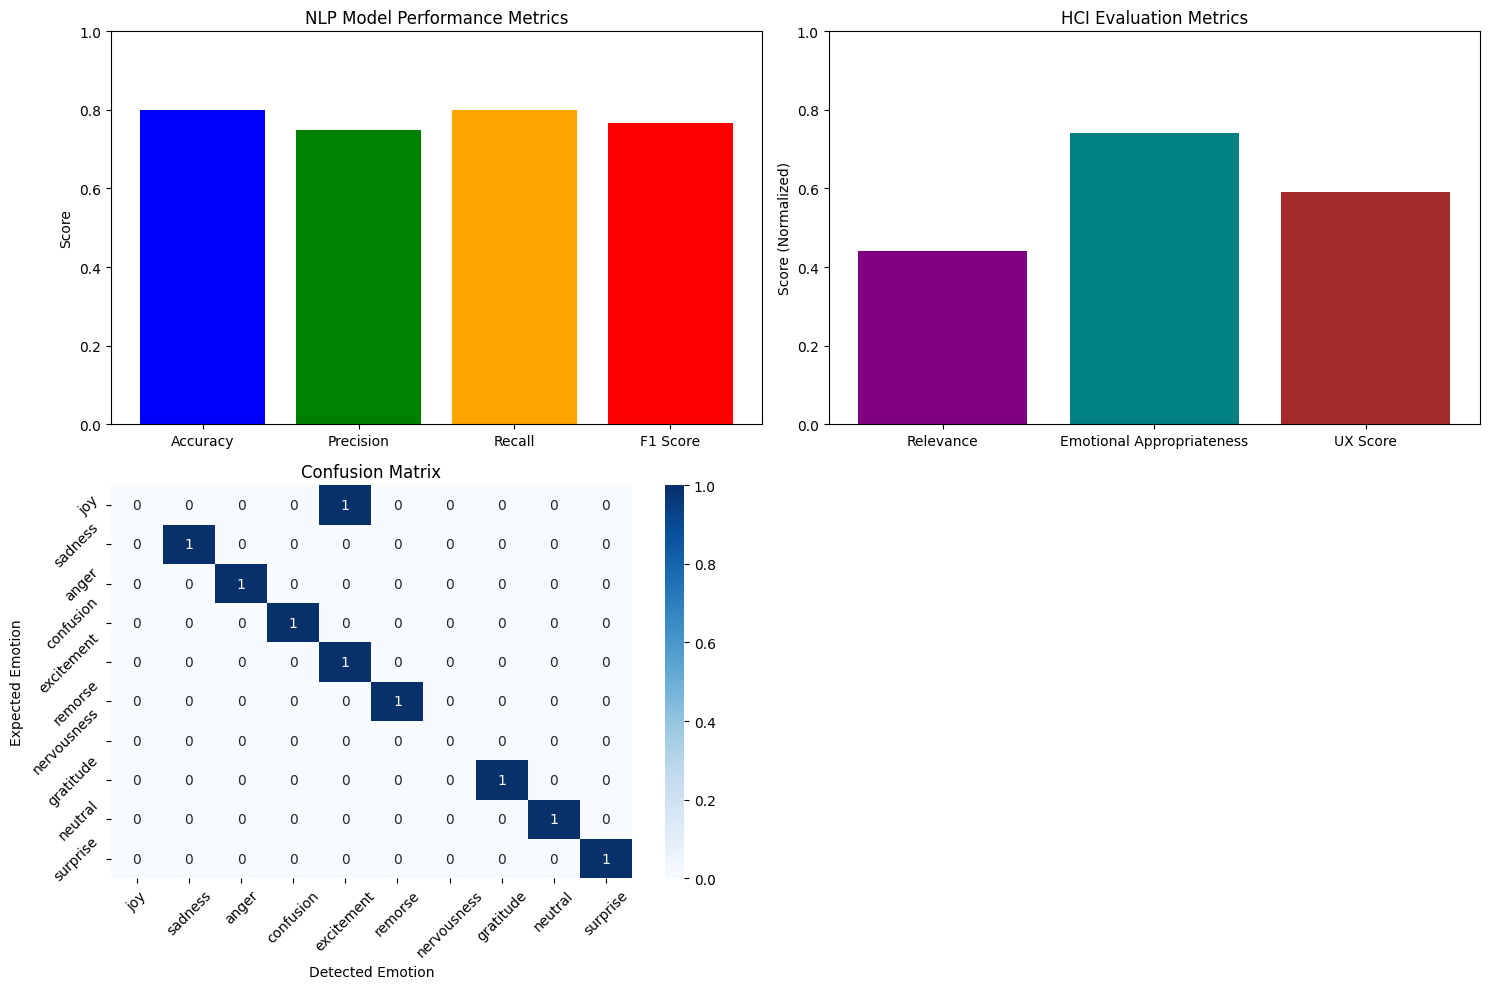

In [ ]:
visualize_evaluation_results(evaluation_results)